In [12]:
import matplotlib.image as mpimg
stads_logo = mpimg.imread('stads_logo.png')

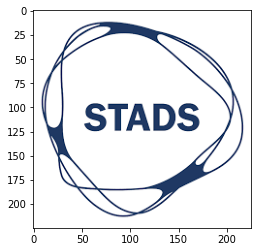

In [13]:
import matplotlib.pyplot as plt

plt.imshow(stads_logo)

In [ ]:
import scipy
import numpy as np

img = mpimg.imread('stads_logo.png')
inputs = [50, 100]

width, height = img.shape
density = scipy.interpolate.RectBivariateSpline(
        x=np.arange(width),
        y=np.arange(height),
        z=img)

    """Evaluates the density of the image at the given point."""
x, y = inputs
if x < 0 or x > width or y < 0 or y > height:
    log_dens = np.array([np.log(0)])
else:
    log_dens = np.log(self.density(x, y))[0]

In [15]:
#density estimation

class ImageLikelihood():
    """
    Custom theano op for turning a 2d intensity matrix into a density
    distribution.
    """

    def __init__(self, img):
        self.width, self.height = img.shape
        self.density = scipy.interpolate.RectBivariateSpline(
            x=np.arange(self.width),
            y=np.arange(self.height),
            z=img)

    def perform(self, node, inputs, output_storage):
        """Evaluates the density of the image at the given point."""
        x, y = inputs[0]
        if x < 0 or x > self.width or y < 0 or y > self.height:
            output_storage[0][0] = np.array([np.log(0)])
        else:
            output_storage[0][0] = np.log(self.density(x, y))[0]

In [19]:
def load_image(image_file, mode=None):
    """Load filename into a numpy array, filling in transparency with 0's.

    Parameters
    ----------
    image_file : str
        File to load. Usually works with .jpg and .png.

    Returns
    -------
    numpy.ndarray of resulting image. Has shape (w, h), (w, h, 3), or (w, h, 4)
        if black and white, color, or color with alpha channel, respectively.
    """
    image = Image.open(image_file)
    if mode is None:
        mode = image.mode
    alpha = image.convert('RGBA').split()[-1]
    background = Image.new("RGBA", image.size, (255, 255, 255, 255,))
    background.paste(image, mask=alpha)
    img = np.flipud(np.asarray(background.convert(mode)))
    img = img / 255
    if mode == 'L':  # I don't know how images work, but .png's are inverted
        img = 1 - img
    return img

In [22]:
import scipy
import pymc3 as pm


img = load_image('stads_logo.png')
ImageLikelihood(img = img)

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [23]:
def sample_grayscale(image, samples=5000, tune=100, nchains=4, threshold=0.2):
    """Run MCMC on a 1 color image. Works best on logos or text.

    Parameters
    ----------
    image : numpy.ndarray
        Image array from `load_image`.  Should have `image.ndims == 2`.

    samples : int
        Number of samples to draw from the image

    tune : int
        Number of tuning steps to take. Note that this adjusts the step size:
            if you want smaller steps, make tune closer to 0.

    nchains : int
        Number of chains to sample with. This will later turn into the number
        of colors in your plot. Note that you get `samples * nchains` of total
        points in your final scatter.

    threshold : float
        Float between 0 and 1. It looks nicer when an image is binarized, and
        this will do that. Use `None` to not binarize. In theory you should get
        fewer samples from lighter areas, but your mileage may vary.

    Returns
    -------
    pymc3.MultiTrace of samples from the image. Each sample is an (x, y) float
        of indices that were sampled, with the variable name 'image'.
    """
    # preprocess
    image_copy = image.copy()
    if threshold != -1:
        image_copy[image < threshold] = 0
        image_copy[image >= threshold] = 1

    # need an active pixel to start on
    active_pixels = np.array(list(zip(*np.where(image_copy == image_copy.max()))))
    idx = np.random.randint(0, len(active_pixels), nchains)
    start = active_pixels[idx]

    with pm.Model():
        pm.DensityDist('image', ImageLikelihood(image_copy), shape=2)
        trace = pm.sample(samples,
                          tune=tune,
                          chains=nchains, step=pm.Metropolis(),
                          start=[{'image': x} for x in start],
                         )
    return trace

In [24]:
image = load_image('stads_logo.png', 'L')
trace = sample_grayscale(image, samples=1000, tune=500, nchains=6, threshold=0.1)

TypeError: 'ImageLikelihood' object is not callable